## Описание проекта

Компания «Такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется модель для такого предсказания.

Требование заказчика :
RMSE на тестовой выборке <= 48.



## Содержание проекта:
* [1. Подготовка датафрейма.](#1-bullet)
* [2. Анализ данных.](#2-bullet)
* [3. Обучение моделей.](#3-bullet)
* [4. Тестирование полученных моделей.](#4-bullet)


<a id='1-bullet'></a>

# 1. Подготовка датафрейма 

Начнем же подготовку к нашему проекту с портирования всяких нужных нам впоследствии библиотек:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

Начало положено!

Теперь посмотрим на датафрейм:

In [3]:
df =  pd.read_csv('C:/Users/mi/Downloads/taxi.csv', index_col = [0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Во-первых, у нас задача состоит в исследовании заказов по часам. Во-вторых, возможно некоторые части датафрейма стоят не на своих местах. Начнем же исправление:

In [4]:
df.index = pd.to_datetime(df.index)
df = df.resample('1H').sum()

df.sort_index()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Выглядит лучше. Определенно, в упорядоченных данных есть своя эстетика. Но продолжим рассматривать наши данные.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


С 2018-03-01 00:00:00 по 2018-08-31 23:00:00. Любопытный почти полугодовой срез данных. 

In [6]:
df_for_models = df.copy()

Сделаем копию нашего датафрейма, так как некоторые факторы, которые мы будем рассматривать в контексте исследования данных, нам не пригодятся.

<a id='2-bullet'></a>

# 2. Анализ данных

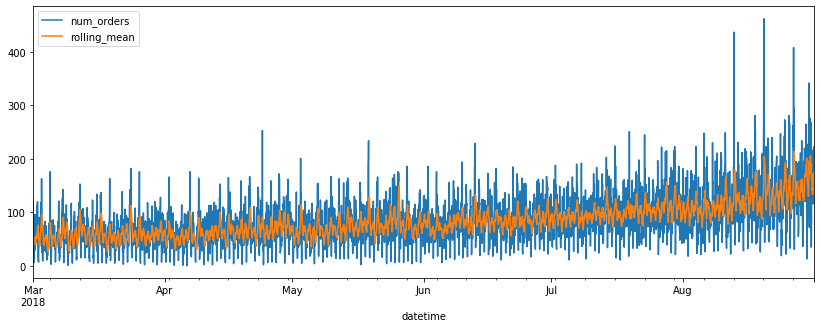

In [7]:
df_roll = df.copy()
df_roll['rolling_mean'] = df.rolling(10).mean()

df_roll.plot(figsize = (14, 5))

Во-первых, отметим, что датафрейм содержит данные на месяца  марта по сентябрь (где-то полгода собранных данных по заказам такси). В дальнейшем анализе (когда будем касаться сезонности) нам нужно учитывать, что данных недостаточно для определения квартальной сезонности и годовой, то есть построить модель для прогнозирования заказов такси будет некорректно для ,скажем, зимнего периода. 

Посмотрим же на график скользящего среднего. Можно с уверенностью заключить, что среднее повышается с течением времени. Сохраним это в уме, для дальнейших выводов.

Теперь посмотрим на сезонность всего происходящего:

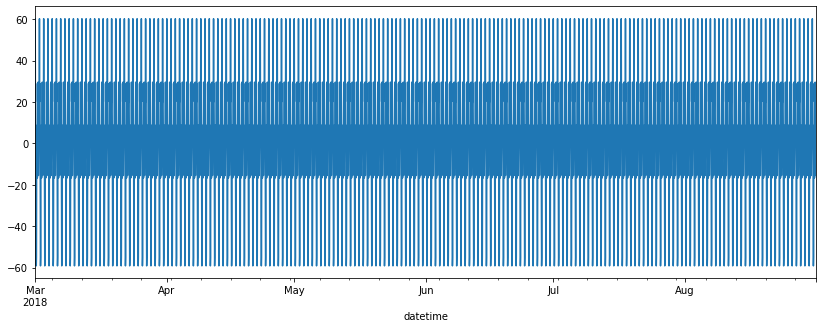

In [8]:
decomposed = seasonal_decompose(df)
decomposed.seasonal.plot(ax = plt.gca(), figsize = (14, 5))

Если брать весь период, то ничего вообще не разобрать. Давайте посмотрим на первую половину марта:

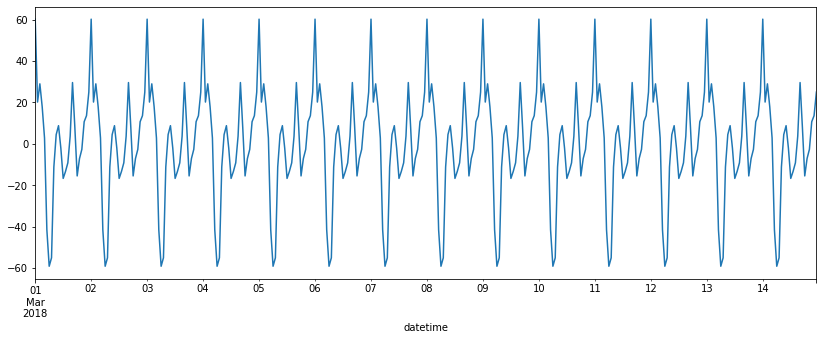

In [9]:
decomposed.seasonal['2018-03':'2018-03-14'].plot(ax = plt.gca(), figsize = (14, 5))

Очевидно вырисовывается цикличный рисунок. Судя по всему цикличность имеет ежедневный характер.

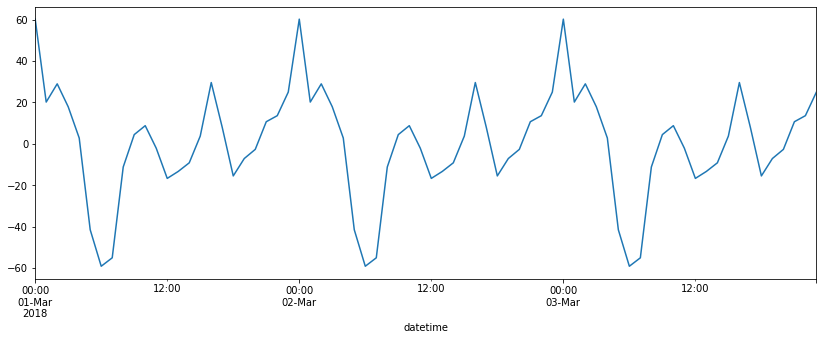

In [10]:
decomposed.seasonal['2018-03':'2018-03-3'].plot(ax = plt.gca(), figsize = (14, 5))

Отметим цикличный характер данного вида : в начале суток заказов имеется довольно большое количество, затем снижается где-то до 5-6 утра(что очевидно, если держать в уме примерно картину жизнедейтельности людей), далее повышение до 10 утра,коррекция, повышение до 3-4 часов дня, а затем достижение дневного( или, если быть дотошным, то ночного) максимума.

Давайте проанализируем тренд. Также выведем график остатков вместе с ним.

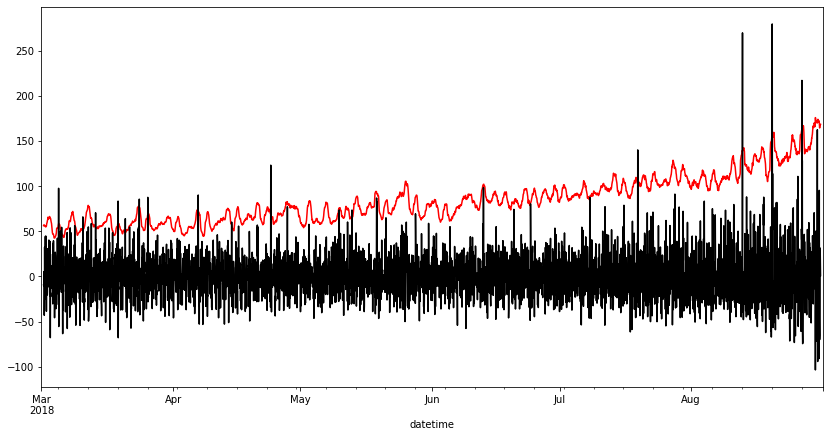

In [11]:
decomposed.trend.plot(ax = plt.gca(), color = "red", figsize = (14,7), label = 'trend')
decomposed.resid.plot(ax = plt.gca(), figsize = (14, 7), color = 'black', label = 'residuals')

А если смотреть на цельную картину всего "происходящего", то можно, во-первых, констатировать тренд на повышение количества заказов с течением времени. Во-вторых, довольно сильно расширяется диапазон значений остатков, которые не объясняются ни трендом, ни сезонностью. Это тоже нужно принять во внимание.

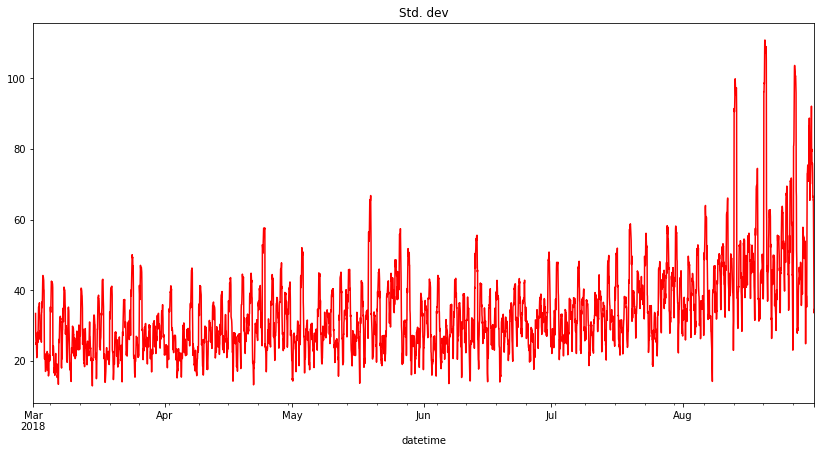

In [12]:
df_roll['std'] = df_roll['num_orders'].rolling(15).std()
df_roll['std'].plot(color = 'red', title = 'Std. dev', figsize = (14, 7))

Скользящее стандартное отклонение так и шепчет: это не стационарный временной ряд. По графику видно, как станд. отклонение меняется, да и среднее значенние ряда тоже растет. Что это нам дает ? Вопрос хороший.
Ответ на него: более сложное прогнозирование.

In [13]:
df_roll_1 = df_roll.copy()

Поиграемся с сопоставлением скользящих средних и стандартных отклонений в стандартном временном ряду и в контексте преобразования с помощью разностей временного ряда.

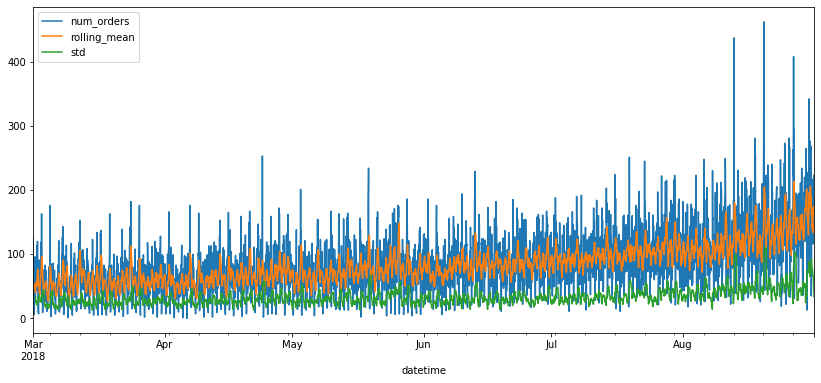

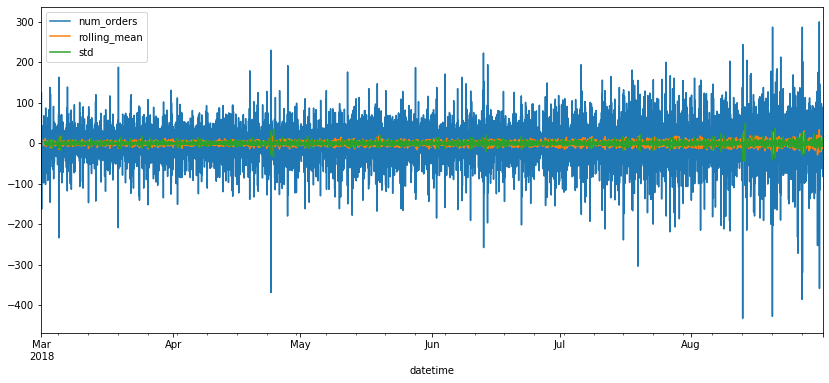

In [56]:
df_roll_1.plot(figsize = (14,6))
shift  = df_roll.shift(fill_value = 0) 

df_roll = df_roll - shift

df_roll.plot(figsize = (14,6))

ДА! Это близко к тому, что называется стационарным временным рядом! С этим можно и дать поработать нашим моделям. 

<a id='3-bullet'></a>

# 3. Обучение моделей

In [15]:
shift = df_for_models.shift(fill_value = 0)

In [16]:
df_for_models = df_for_models - shift

In [17]:
df_for_models

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,-39
2018-03-01 02:00:00,-14
2018-03-01 03:00:00,-5
2018-03-01 04:00:00,-23
...,...
2018-08-31 19:00:00,-71
2018-08-31 20:00:00,18
2018-08-31 21:00:00,5


In [18]:
def make_features(max_lag, rolling_mean_size):
    df_for_models['dayofweek'] = df_for_models.index.dayofweek
    df_for_models['hour'] = df_for_models.index.hour
    for lag in range(1, max_lag + 1):
        df_for_models['lag_{}'.format(lag)] = df_for_models['num_orders'].shift(lag)
        
    df_for_models['rolling_mean'] = df_for_models['num_orders'].shift().rolling(rolling_mean_size).mean()

Насчет факторов :<br> 
1) Некоторые факторы в контексте того, что у нас датафрейм дан за полгода, просто теряют свою значимость. А если быть точным фактор год, так как он един для всех данных.<br>
2) Скользящее среднее точно необходимо, так данный фактор позволяет модели прощупать линию тренда<br>
3) По аналогии с скользящим средним лаг нужен чтобы определить влияние предыдущих событий на текущие<br>

In [19]:
make_features(24,10)

train, test = train_test_split(df_for_models, test_size = 0.1, shuffle = False)
train = train.dropna()
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [20]:
train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

Я предлагаю обучить несколько моделей для данной задачи : классическую линейную регрессию, модель градиентного бустинга CatBoost и ее конкурента LightGBM.

In [21]:
linear_model = LinearRegression()
linear_model.fit(train_features, train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
cat_model_0 = CatBoostRegressor()
cat_model_0.fit(train_features, train_target, verbose = 100)

Learning rate set to 0.049842
0:	learn: 35.7276619	total: 168ms	remaining: 2m 47s
100:	learn: 24.1183230	total: 1.24s	remaining: 11s
200:	learn: 21.2771963	total: 2.61s	remaining: 10.4s
300:	learn: 18.9793337	total: 3.8s	remaining: 8.82s
400:	learn: 17.2063690	total: 5.18s	remaining: 7.74s
500:	learn: 15.6857688	total: 7.29s	remaining: 7.26s
600:	learn: 14.5469560	total: 9.21s	remaining: 6.12s
700:	learn: 13.5468836	total: 11s	remaining: 4.67s
800:	learn: 12.5802251	total: 13s	remaining: 3.23s
900:	learn: 11.7479917	total: 14.1s	remaining: 1.54s
999:	learn: 10.9963591	total: 15.5s	remaining: 0us


In [23]:
cat_model = CatBoostRegressor()

grid = {'learning_rate': [0.01, 0.2],
        'depth': [4, 6, 10],
        'iterations' : [30,100],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result_1 = cat_model.grid_search(grid, 
                                       X=train_features, 
                                       y=train_target,
                                       shuffle = False,
                                       verbose = 10)



bestTest = 43.63194478
bestIteration = 29

0:	loss: 43.6319448	best: 43.6319448 (0)	total: 364ms	remaining: 21.5s

bestTest = 35.69758485
bestIteration = 29


bestTest = 43.66506953
bestIteration = 29


bestTest = 36.06348661
bestIteration = 29


bestTest = 43.71471171
bestIteration = 29


bestTest = 35.85191176
bestIteration = 29


bestTest = 43.74380069
bestIteration = 29


bestTest = 36.11870378
bestIteration = 29


bestTest = 43.76314451
bestIteration = 29


bestTest = 36.11245485
bestIteration = 29


bestTest = 40.56900015
bestIteration = 99

10:	loss: 40.5690001	best: 35.6975848 (1)	total: 3.22s	remaining: 14.4s

bestTest = 33.32801994
bestIteration = 98


bestTest = 40.63410704
bestIteration = 99


bestTest = 33.587056
bestIteration = 99


bestTest = 40.73350577
bestIteration = 99


bestTest = 33.69847836
bestIteration = 98


bestTest = 40.78407392
bestIteration = 99


bestTest = 33.56171036
bestIteration = 99


bestTest = 40.84472556
bestIteration = 99


bestTest = 33.68979475

In [24]:
lgbm_model = LGBMRegressor()
lgbm_model.fit(train_features, train_target)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [25]:
%%time

param_grid = {
    'learning_rate': [0.01, 0.2],
    'depth': [4, 6, 10],
    'iterations' : [40,50],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }


lgb_estimator = lgb.LGBMRegressor()

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)

lgb_model = gsearch.fit(train_features, train_target)

print(lgb_model.best_params_, lgb_model.best_score_)

{'depth': 4, 'iterations': 40, 'lambda_l1': 1.5, 'lambda_l2': 1, 'learning_rate': 0.2} 0.48160191716870987
Wall time: 1min 40s


После относительно долгого грид-серча модель наконец сгенерирована с нужными параметрами. Эта победа далась нам тяжкой ценой. Ценой всего....

<a id='4-bullet'></a>

# 4. Тестирование полученных моделей

Начнем же тестирование нашей модели на тестовой части датафрейма.

In [52]:
result_data = pd.DataFrame(columns = ['model_name', 'rmse_test'])

In [37]:
def predicted(model):
    predictions = model.predict(test_features)
    return predictions 
    
def checking(model, predictions):
    rmse = mean_squared_error(predictions, test_target) ** 0.5
    return result_data.append({'model_name' : "{}".format(model), 'rmse_test' : rmse}, ignore_index=True)
   

In [28]:
def plotting(model_name):
    plotting = pd.DataFrame(columns = ['target','predictions'])
    predictions = predicted(model_name)
    plotting['target'] = test_target
    plotting['predictions'] = predictions
    
    plotting['2018-08-13':'2018-08-16'].plot(figsize = (14,6))

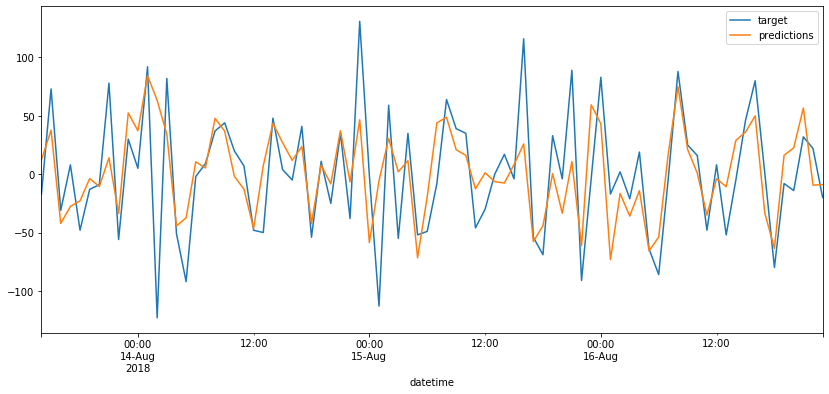

In [29]:
plotting(linear_model)

Прогнозируемые значения в целом почти копируют реальную картину, но крайне усредненно. Особенно ярко выражено это в разнице в чем-то ,что смахивает на выброс(где гигантская пропасть в заказах где-то в два часа начи 14 августа и где всплеск заказов где-то в 22-23 часа того же дня)

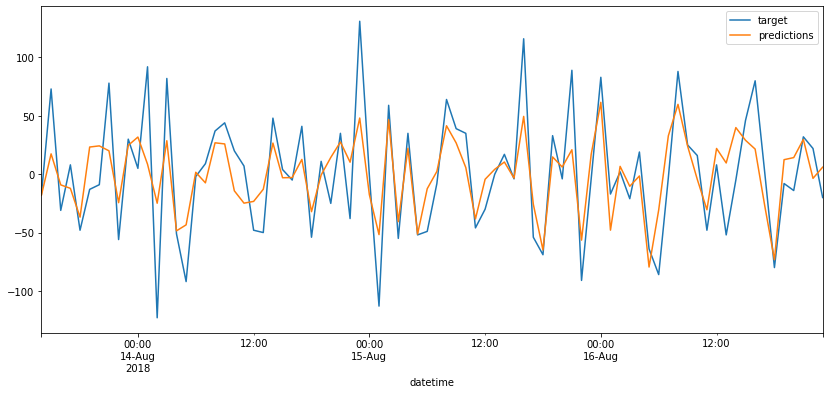

In [30]:
plotting(cat_model_0)

Тут ситуация аналогичная предыдущему графику. А что будет, если посмотреть на картину целиком?

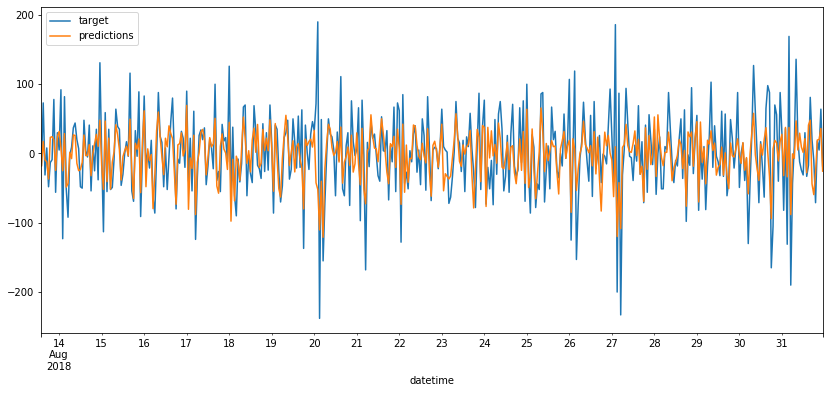

In [31]:
plotting_1 = pd.DataFrame(columns = ['target','predictions'])
predicted_cat_0 = predicted(cat_model_0)
plotting_1['target'] = test_target
plotting_1['predictions'] = predicted_cat_0

plotting_1.plot(figsize = (14,6))

А если смотреть на карнтину в целом, то вывод подтверждается, что основные проблемы с прогнозированием в тех местах, где есть очевидные статистические выбросы(то есть в районе 20-го, 27-го чисел)

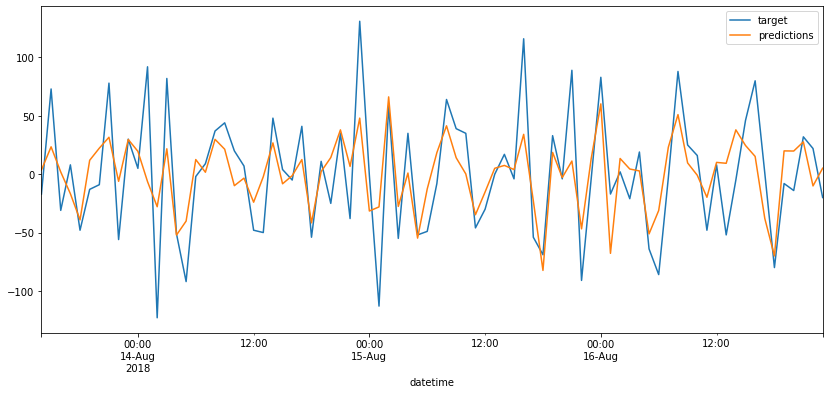

In [32]:
plotting(cat_model)

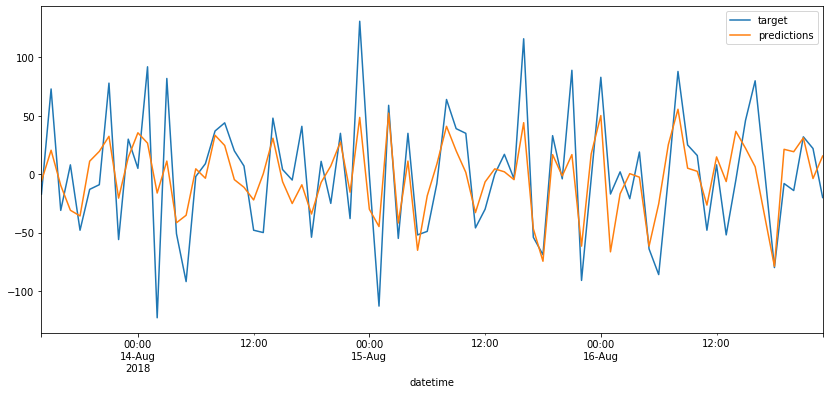

In [33]:
plotting(lgbm_model)

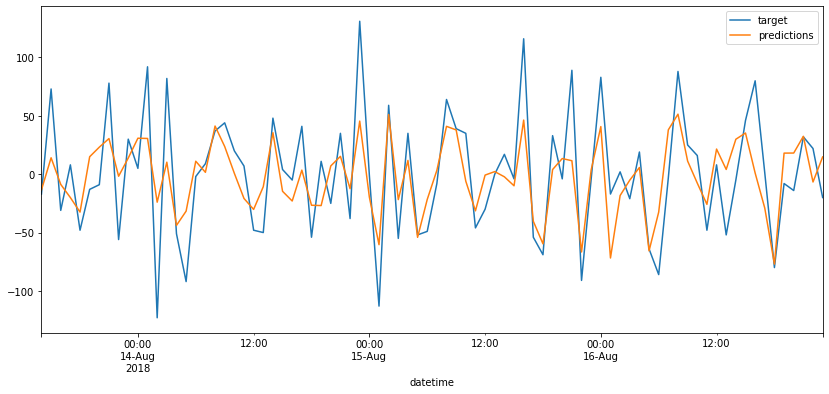

In [34]:
plotting(lgb_model)

In [53]:
models = [linear_model,cat_model_0,cat_model,lgbm_model,lgb_model]

In [54]:
for model in models:
    result_data = checking(model, predicted(model))

In [55]:
result_data.sort_values('rmse_test', ascending = True)

,model_name,rmse_test
1,<catboost.core.CatBoostRegressor object at 0x0...,42.077317
4,"GridSearchCV(cv='warn', error_score='raise-dep...",42.781470
3,"LGBMRegressor(boosting_type='gbdt', class_weig...",42.871588
2,<catboost.core.CatBoostRegressor object at 0x0...,44.438785
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",45.070274


Условие в rmse < 48 успешно выполнено на всех моделях. Лучше всего себя показали на тестовой выборке нетронутая модель Кэтбуста и такая же девственно чистая модель линейной регрессии... Даже чутка обидно за модель, которая сьела все доступное и недоступное время на поиски оптимальных параметров....